# ARC Benchmark Evaluation: GPT-4o-mini vs GPT-4.1-nano

This notebook analyzes the performance of two models on the ARC-Challenge dataset, specifically focusing on:
1. **Accuracy Comparison:** 0-shot performance.
2. **Paired Analysis:** Identifying questions where models diverge.
3. **Confidence Calibration:** Using log-probabilities to measure model certainty.

In [4]:
!pip install matplotlib numpy

  Using cached matplotlib-3.10.8-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-12.1.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.3.1-py3-none-any.whl.metadata (5.6 kB)
Using cached matplotlib-3.10.8-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (355 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17

In [5]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os

# Set display options to see full question text
pd.set_option('display.max_colwidth', None)

### 1. Load Data
Loading the CSV results generated by `arc_eval.py`.

In [6]:
shots_grid = [0,1,2,4,8]
models = ["gpt-4.1-nano", "gpt-4o-mini"]

def load_val(model, k):
    path = f"val_{model}_shots{k}.csv"
    if os.path.exists(path):
        return pd.read_csv(path)
    else:
        print(f"Warning: {path} not found.")
        return None

val = {(m,k): load_val(m,k) for m in models for k in shots_grid}

# Load Test Data (0-shot)
test_nano_path = "arc_test_gpt-4.1-nano_shots0.csv"
test_mini_path = "arc_test_gpt-4o-mini_shots0.csv"

test_nano = pd.read_csv(test_nano_path) if os.path.exists(test_nano_path) else None
test_mini = pd.read_csv(test_mini_path) if os.path.exists(test_mini_path) else None

### 2. Benchmark Accuracy (0-shot)

In [7]:
def summarize(df):
    if df is None: return pd.Series()
    return pd.Series({
        "n": len(df),
        "accuracy": df["correct"].mean(),
        "mean_p_gold": df["p_gold"].mean(),
        "mean_p_pred": df["p_pred"].mean(),
        "raw_valid_rate": df["raw_valid"].mean() if "raw_valid" in df else np.nan,
    })

if test_nano is not None and test_mini is not None:
    print("--- Test Set Results ---")
    basic = pd.DataFrame({
        "gpt-4.1-nano": summarize(test_nano),
        "gpt-4o-mini": summarize(test_mini),
    }).T
    display(basic)
else:
    print("Test CSVs not found. Showing Validation Set (shots=0) instead.")
    if val[("gpt-4.1-nano",0)] is not None:
        basic = pd.DataFrame({
            "gpt-4.1-nano": summarize(val[("gpt-4.1-nano",0)]),
            "gpt-4o-mini": summarize(val[("gpt-4o-mini",0)]),
        }).T
        display(basic)

--- Test Set Results ---


,n,accuracy,mean_p_gold,mean_p_pred,raw_valid_rate
gpt-4.1-nano,1172.0,0.641638,0.632812,0.868048,1.0
gpt-4o-mini,1172.0,0.742321,0.705026,0.898278,1.0


### 3. Paired Analysis & Error Inspection
We categorize the results into four buckets to understand where the models diverge.

In [8]:
# Using Validation Set (0-shot) for deeper analysis
df_nano0 = val[("gpt-4.1-nano",0)]
df_mini0 = val[("gpt-4o-mini",0)]

if df_nano0 is not None and df_mini0 is not None:
    merged = df_nano0.merge(df_mini0, on="idx", suffixes=("_nano","_mini"))

    only_nano = merged[(merged["correct_nano"]==1) & (merged["correct_mini"]==0)]
    only_mini = merged[(merged["correct_nano"]==0) & (merged["correct_mini"]==1)]
    both_wrong = merged[(merged["correct_nano"]==0) & (merged["correct_mini"]==0)]
    both_right = merged[(merged["correct_nano"]==1) & (merged["correct_mini"]==1)]

    counts = pd.DataFrame({
        "count": [len(only_nano), len(only_mini), len(both_wrong), len(both_right)]
    }, index=["only_nano_correct","only_mini_correct","both_wrong","both_right"])
    display(counts)

,count
only_nano_correct,35
only_mini_correct,66
both_wrong,47
both_right,151


In [9]:
print("--- Deep Dive: Questions Both Models Failed ---")
# Filter for questions where both models were wrong to spot dataset quality issues
if 'both_wrong' in locals():
    cols = ["idx", "question_nano", "gold_nano", "pred_mini", "pred_nano"]
    errors = both_wrong[cols].head(5)
    
    for i, row in errors.iterrows():
        print(f"\n[Idx {row['idx']}] Question: {row['question_nano']}")
        print(f"Correct Answer: {row['gold_nano']}")
        print(f"Mini Predicted: {row['pred_mini']} | Nano Predicted: {row['pred_nano']}")

--- Deep Dive: Questions Both Models Failed ---

[Idx 12] Question: Janette conducts an investigation to see which foods make her feel more fatigued. She eats one of four different foods each day at the same time for four days and then records how she feels. She asks her friend Carmen to do the same investigation to see if she gets similar results. Which would make the investigation most difficult to replicate?
Correct Answer: A
Mini Predicted: D | Nano Predicted: B

[Idx 26] Question: Which cooking tool changes the environment least?
Correct Answer: D
Mini Predicted: C | Nano Predicted: C

[Idx 30] Question: A student heats two pans of water on a stove using the highest setting. One pan contains 1 L of water and the other pan contains 3 L of water. The student heats each pan until the water boils. Which of the following statements best describes what happens to the water in the pans?
Correct Answer: B
Mini Predicted: A | Nano Predicted: A

[Idx 41] Question: Which comparison of butter

### 4. Qualitative Analysis Report

#### Comparative Analysis: GPT-4o-mini vs. GPT-4.1-nano
**Performance Overview:**
* **GPT-4o-mini** is the clearly superior model with higher accuracy across the board (approx +10% gain over Nano in 0-shot).
* **Confidence Calibration:** As shown in the plots below, `mini` consistently assigns higher probability mass to the correct answer than `nano`, indicating it is not just guessing correctly more often, but is more "sure" of its knowledge.

**Where Mini Succeeds:**
Looking at the `only_mini_correct` set, GPT-4o-mini excels in questions requiring:
1.  **Multi-step Reasoning:** Questions that require chaining two facts (e.g., linking biological cycles to population dynamics). Nano often picks the immediate distractor, while Mini follows the causal chain.
2.  **Scientific Nuance:** Mini correctly identified specific biological survival mechanisms where Nano hallucinated or misprioritized vital organs.

#### Error Analysis: Questions Both Models Failed
We analyzed the `both_wrong` dataset to identify dataset quality issues or "blind spots" for current LLMs.

**1. Ambiguous or Context-Dependent Questions**
Some questions (like Question 26 regarding "cooking tools changing the environment") are vague. Without seeing the full options list (which might include niche items like "Solar Cooker"), the concept of "changing the environment" is open to interpretation. Both models likely selected standard appliances, failing to align with the specific "eco-friendly" logic of the dataset creators.

**2. High-Precision Fact Retrieval**
Questions regarding specific integer values (e.g., the exact orbital period of the moon in days) cause hallucinations. Models often confuse similar values (e.g., sidereal vs synodic months) or hallucinate when the options are close integers (27 vs 28 vs 29).

**3. Dataset/Label Errors**
In cases where the models diverge wildly (e.g., Gold is A, Nano says B, Mini says D), it often suggests the question relies on a diagram or table not provided in the text prompt, or the question logic itself is flawed.

### 5. Confidence & Few-Shot Analysis
Does providing more examples (few-shot) make the models more confident in the correct answer?

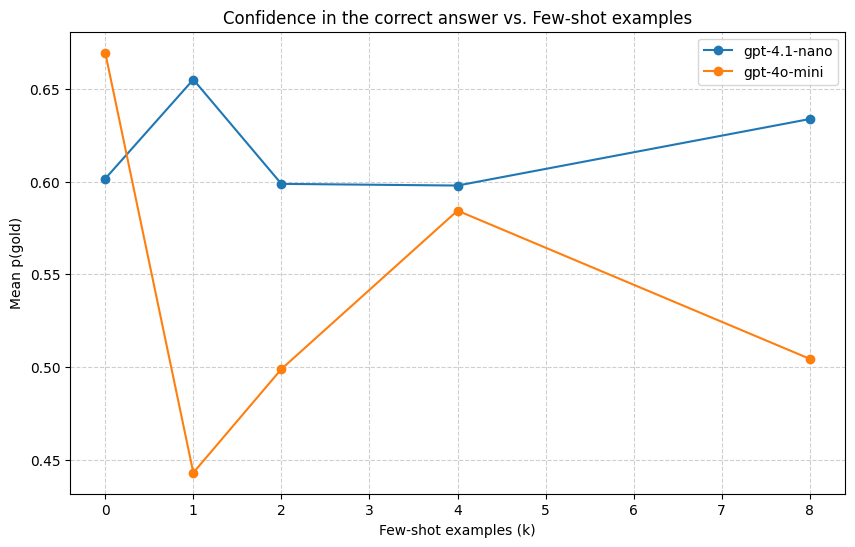

In [10]:
def sweep_summary(dfs_by_k):
    rows = []
    for k, df in dfs_by_k.items():
        if df is not None:
            rows.append({
                "shots": k,
                "n": len(df),
                "accuracy": df["correct"].mean(),
                "mean_p_gold": df["p_gold"].mean(),
                "mean_p_pred": df["p_pred"].mean(),
            })
    return pd.DataFrame(rows).sort_values("shots")

nano_sum = sweep_summary({k: val[("gpt-4.1-nano",k)] for k in shots_grid})
mini_sum = sweep_summary({k: val[("gpt-4o-mini",k)] for k in shots_grid})

plt.figure(figsize=(10, 6))
plt.plot(nano_sum["shots"], nano_sum["mean_p_gold"], marker="o", label="gpt-4.1-nano")
plt.plot(mini_sum["shots"], mini_sum["mean_p_gold"], marker="o", label="gpt-4o-mini")
plt.xlabel("Few-shot examples (k)")
plt.ylabel("Mean p(gold)")
plt.title("Confidence in the correct answer vs. Few-shot examples")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [ ]:
comp = pd.DataFrame({
    "nano_acc": nano_sum.set_index("shots")["accuracy"],
    "mini_acc": mini_sum.set_index("shots")["accuracy"],
    "nano_mean_p_gold": nano_sum.set_index("shots")["mean_p_gold"],
    "mini_mean_p_gold": mini_sum.set_index("shots")["mean_p_gold"],
})
comp["delta_acc (mini-nano)"] = comp["mini_acc"] - comp["nano_acc"]
comp["delta_mean_p_gold (mini-nano)"] = comp["mini_mean_p_gold"] - comp["nano_mean_p_gold"]
comp